In [1]:
!pip install xgboost lightgbm catboost --quiet

In [2]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire


🚀 Training: Logistic Regression
✅ F1 Score: 0.5948
              precision    recall  f1-score   support

      재직자(0)       0.60      0.60      0.60      2000
      퇴사자(1)       0.60      0.59      0.59      2000

    accuracy                           0.60      4000
   macro avg       0.60      0.60      0.60      4000
weighted avg       0.60      0.60      0.60      4000


🚀 Training: Random Forest
✅ F1 Score: 0.8291
              precision    recall  f1-score   support

      재직자(0)       0.86      0.76      0.81      2000
      퇴사자(1)       0.78      0.88      0.83      2000

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000


🚀 Training: XGBoost
✅ F1 Score: 0.9960
              precision    recall  f1-score   support

      재직자(0)       1.00      0.99      1.00      2000
      퇴사자(1)       0.99      1.00      1.00      2000

    accuracy                           1.00 

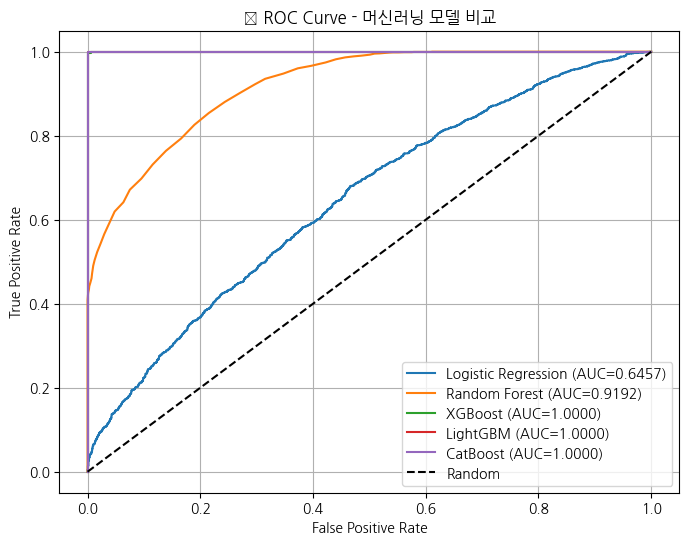


📊 [최종 F1 Score 정리]
Logistic Regression: 0.5948
Random Forest: 0.8291
XGBoost: 0.9960
LightGBM: 0.9993
CatBoost: 0.9988


In [3]:
# 📦 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_curve, auc, classification_report

import warnings
warnings.filterwarnings("ignore")

# 📌 데이터 로드 및 전처리
df = pd.read_csv('/content/employee_new3.csv')
df = df[df['Gender'] != 'Other']
df['Resigned'] = df['Resigned'].astype(int)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=['Resigned', 'Employee_ID', 'Hire_Date'], errors='ignore')
y = df['Resigned']

# 클래스 균형 맞춤
X_0 = X[y == 0].sample(n=10000, random_state=42)
y_0 = y[y == 0].sample(n=10000, random_state=42)
X_1 = X[y == 1]
y_1 = y[y == 1]
repeat_count = 10000 // len(X_1) + 1
X_1_sampled = pd.concat([X_1] * repeat_count)[:10000].reset_index(drop=True)
y_1_sampled = pd.concat([y_1] * repeat_count)[:10000].reset_index(drop=True)

X_balanced = pd.concat([X_0, X_1_sampled]).reset_index(drop=True)
y_balanced = pd.concat([y_0, y_1_sampled]).reset_index(drop=True)

# 결측값 처리 및 스케일링
X_balanced = X_balanced.fillna(X_balanced.mean(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# 📊 모델 리스트 정의
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# 🎯 결과 저장
roc_results = {}
f1_results = {}

# 🔁 모델 학습 및 평가
for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)
    f1 = f1_score(y_test, preds)
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)

    # 저장
    f1_results[name] = f1
    roc_results[name] = (fpr, tpr, auc_score)

    print(f"✅ F1 Score: {f1:.4f}")
    print(classification_report(y_test, preds, target_names=["재직자(0)", "퇴사자(1)"]))

# 📈 ROC Curve 시각화
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc_score) in roc_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.4f})")
plt.plot([0,1],[0,1],'k--',label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - 머신러닝 모델 비교")
plt.legend()
plt.grid()
plt.show()

# 🧾 F1 Score 출력 정리
print("\n📊 [최종 F1 Score 정리]")
for name, score in f1_results.items():
    print(f"{name}: {score:.4f}")


🚀 Training: Logistic Regression
✅ F1 Score: 0.5948
              precision    recall  f1-score   support

      재직자(0)       0.60      0.60      0.60      2000
      퇴사자(1)       0.60      0.59      0.59      2000

    accuracy                           0.60      4000
   macro avg       0.60      0.60      0.60      4000
weighted avg       0.60      0.60      0.60      4000


🚀 Training: Random Forest
✅ F1 Score: 0.8291
              precision    recall  f1-score   support

      재직자(0)       0.86      0.76      0.81      2000
      퇴사자(1)       0.78      0.88      0.83      2000

    accuracy                           0.82      4000
   macro avg       0.82      0.82      0.82      4000
weighted avg       0.82      0.82      0.82      4000


🚀 Training: XGBoost
✅ F1 Score: 0.9960
              precision    recall  f1-score   support

      재직자(0)       1.00      0.99      1.00      2000
      퇴사자(1)       0.99      1.00      1.00      2000

    accuracy                           1.00 

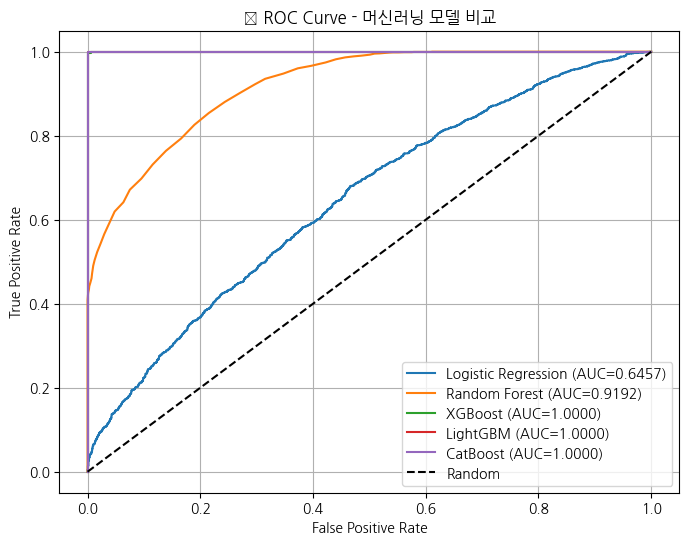


📊 [최종 F1 Score 정리]
Logistic Regression: 0.5948
Random Forest: 0.8291
XGBoost: 0.9960
LightGBM: 0.9993
CatBoost: 0.9988


In [4]:
# 📦 라이브러리 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, roc_curve, auc, classification_report

import warnings
warnings.filterwarnings("ignore")

# 📌 데이터 로드 및 전처리
df = pd.read_csv('/content/employee_new3.csv')
df = df[df['Gender'] != 'Other']
df['Resigned'] = df['Resigned'].astype(int)
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop(columns=['Resigned', 'Employee_ID', 'Hire_Date'], errors='ignore')
y = df['Resigned']

# 클래스 균형 맞춤
X_0 = X[y == 0].sample(n=10000, random_state=42)
y_0 = y[y == 0].sample(n=10000, random_state=42)
X_1 = X[y == 1]
y_1 = y[y == 1]
repeat_count = 10000 // len(X_1) + 1
X_1_sampled = pd.concat([X_1] * repeat_count)[:10000].reset_index(drop=True)
y_1_sampled = pd.concat([y_1] * repeat_count)[:10000].reset_index(drop=True)

X_balanced = pd.concat([X_0, X_1_sampled]).reset_index(drop=True)
y_balanced = pd.concat([y_0, y_1_sampled]).reset_index(drop=True)

# 결측값 처리 및 스케일링
X_balanced = X_balanced.fillna(X_balanced.mean(numeric_only=True))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

# 📊 모델 리스트 정의
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# 🎯 결과 저장
roc_results = {}
f1_results = {}

# 🔁 모델 학습 및 평가
for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)
    f1 = f1_score(y_test, preds)
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc_score = auc(fpr, tpr)

    # 저장
    f1_results[name] = f1
    roc_results[name] = (fpr, tpr, auc_score)

    print(f"✅ F1 Score: {f1:.4f}")
    print(classification_report(y_test, preds, target_names=["재직자(0)", "퇴사자(1)"]))

# 📈 ROC Curve 시각화
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc_score) in roc_results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.4f})")
plt.plot([0,1],[0,1],'k--',label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve - 머신러닝 모델 비교")
plt.legend()
plt.grid()
plt.show()

# 🧾 F1 Score 출력 정리
print("\n📊 [최종 F1 Score 정리]")
for name, score in f1_results.items():
    print(f"{name}: {score:.4f}")